# Data Selection for Modeling

This notebook loads the cleaned dataset, filters for entries with a populated Research_Type column, drops the mostly-empty Trial_Phase column, and provides a summary for modeling readiness.

In [ ]:
import pandas as pd
from collections import Counter
from pprint import pprint       
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('preprocessing/cleaned_for_eda.csv')

# Keep only rows where Research_Type is populated (not null/empty)
df = df[df['Research_Type'].notnull() & (df['Research_Type'].str.strip() != '')].copy()

# Drop the Trial_Phase column
if 'Trial_Phase' in df.columns:
        df = df.drop(columns=['Trial_Phase'])

# Display basic info
print(f'Rows with Research_Type: {len(df)}')
print('Columns:', list(df.columns))
df.head()

Rows with Research_Type: 598
Columns: ['PMID', 'Title', 'Abstract', 'Journal', 'Year', 'Authors', 'Cleaned_Abstract', 'Categories', 'Research_Type', 'Diseases', 'Chemicals']


,PMID,Title,Abstract,Journal,Year,Authors,Cleaned_Abstract,Categories,Research_Type,Diseases,Chemicals
0,40603982,Barbigerone attenuates 3-nitropropionic acid-i...,"Huntington's Disease (HD), a neurodegenerative...",Scientific reports,2025.0,Sattam Khulaif Alenezi,huntington disease hd neurodegenerative diseas...,huntington's disease; hd; neurodegenerative di...,clinical_trial,huntington's disease; hd; neurodegenerative di...,barbigerone; malondialdehyde; mda; nitric oxid...
8,40590994,Comparative efficacy and safety of irreversibl...,"Parkinson's disease (PD) is a progressive, neu...",Journal of neurology,2025.0,Marwah Bintay Khalid; Faizan Shahzad; Momina R...,parkinson disease pd progressive neurodegenera...,parkinson's disease; pd; parkinson's disease r...,clinical_trial; review,parkinsons disease; parkinson's disease,safinamide; rasagiline; dopamine; smd
13,40577046,Corticospinal Intermittent Theta Burst Stimula...,Intermittent theta burst stimulation (iTBS) is...,JMIR research protocols,2025.0,Deeksha Patel; Rohit Banerjee; Kamran Farooque...,intermittent theta burst stimulation itbs noni...,cord injury; motor and sensory dysfunction; as...,clinical_trial,cord injury; motor deficit; asia; pain; anxiet...,NaN
18,40572513,Advances in the Exploration of Coordination Co...,Alzheimer's disease (AD) is a progressive neur...,"Molecules (Basel, Switzerland)",2025.0,Jesús Antonio Cruz-Navarro; Luis Humberto Delg...,alzheimer disease ad progressive neurodegenera...,alzheimer's disease; ad; neurodegenerative dis...,review,alzheimers disease; neurodegenerative disorder...,vanadium; oxovanadium; peroxovanadium; protein...
20,40567829,How Do Patients' Fear Prediction and Fear Expe...,Expectancy violation has been proposed as a po...,Depression and anxiety,2025.0,Marina Hilleke; Thomas Lang; Sylvia Helbig-Lan...,expectancy violation propose potential core me...,anxiety; panic disorder; agoraphobia; panic; c...,clinical_trial,anxiety; panic attack; agoraphobia,NaN


In [16]:
num_empty_chemicals = df['Chemicals'].isnull().sum() + (df['Chemicals'].fillna('').str.strip() == '').sum()
print(f"Number of entries with empty Chemicals column: {num_empty_chemicals}")

Number of entries with empty Chemicals column: 231


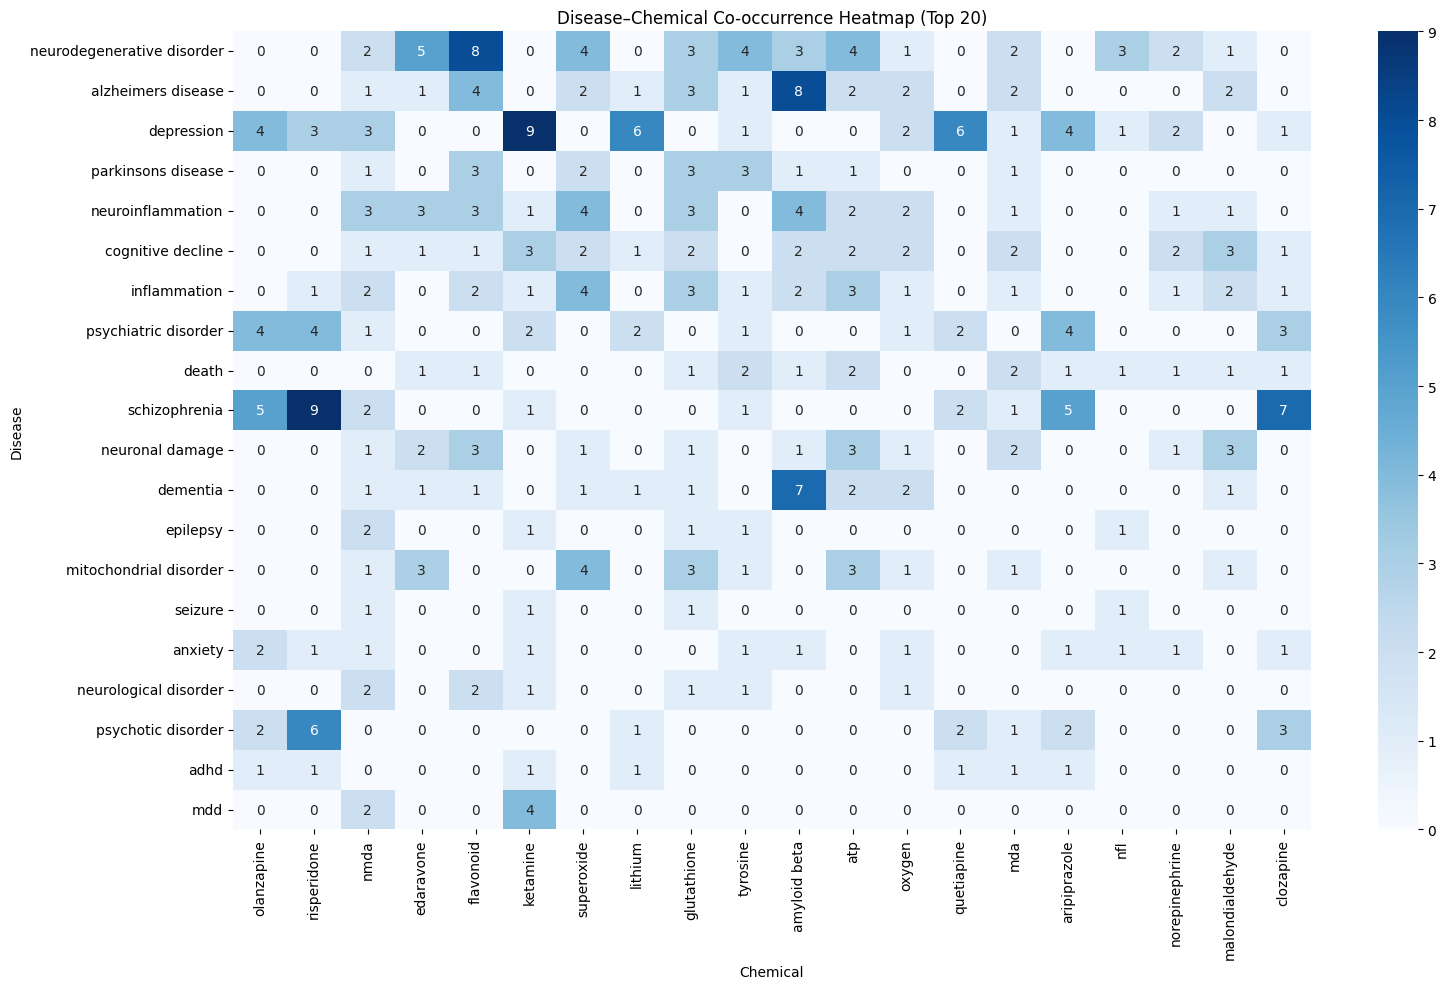

In [ ]:
generic_chemicals = {'antidepressant', 'alcohol', 'smoking', 'smoke', 'nicotine', 'cigarette', 'tobacco', 'dopamine', 'glutamate', 'serotonin', 'calcium','ad'}
generic_diseases ={'cognitive decline', 'death', 'neurodegenerative disorder' }
# Build a list of all chemicals
all_chemicals = []
for entry in df['Chemicals'].dropna():
    all_chemicals.extend([c.strip() for c in entry.split(';') if c.strip()])

# Count occurrences
chemical_counts = Counter(all_chemicals)

# Find singleton chemicals
singleton_chemicals = {chem for chem, count in chemical_counts.items() if count == 1}


def filter_chemicals(chem_str):
    if pd.isna(chem_str) or not chem_str.strip():
        return ''
    chems = [c.strip() for c in chem_str.split(';') if c.strip()]
    # Remove singletons and generic chemicals
    filtered = [c for c in chems if c not in singleton_chemicals and c.lower() not in generic_chemicals]
    return '; '.join(filtered)

# Apply the filter
df['Chemicals'] = df['Chemicals'].apply(filter_chemicals)


disease_chem_pairs = []

for _, row in df.iterrows():
    diseases = [d.strip() for d in str(row['Diseases']).split(';') if d.strip()]
    chemicals = [c.strip() for c in str(row['Chemicals']).split(';') if c.strip()]
    # Only consider rows with both at least one disease and one chemical
    for d, c in itertools.product(diseases, chemicals):
        disease_chem_pairs.append((d, c))

# Count co-occurrences
pair_counts = Counter(disease_chem_pairs)

# Convert to DataFrame for heatmap
if pair_counts:
    pair_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count'])
    pair_df[['Disease', 'Chemical']] = pd.DataFrame(pair_df['Pair'].tolist(), index=pair_df.index)
    pivot = pair_df.pivot_table(index='Disease', columns='Chemical', values='Count', fill_value=0)

    # Optionally, filter to top N diseases/chemicals for visualization
    top_diseases = pivot.sum(axis=1).sort_values(ascending=False).head(20).index
    top_chemicals = pivot.sum(axis=0).sort_values(ascending=False).head(20).index
    filtered_pivot = pivot.loc[top_diseases, top_chemicals]

    plt.figure(figsize=(16, 10))
    sns.heatmap(filtered_pivot, annot=True, fmt='.0f', cmap='Blues')
    plt.title('Disease–Chemical Co-occurrence Heatmap (Top 20)')
    plt.ylabel('Disease')
    plt.xlabel('Chemical')
    plt.tight_layout()
    plt.show()
else:
    print("No disease–chemical pairs found after filtering.")
